In [2]:
#Library
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import seaborn
import numpy as np

from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import multivariate_normal


try:
    import plotly.graph_objects as go

except ImportError:
    print("Please install plotly: pip install plotly")
    pass

try:
    from sklearn.preprocessing import MinMaxScaler 
except ImportError:
    print("Please install scikit-learn: pip install scikit-learn")
    pass


In [3]:
#Dataset import on pandas Data frames
DatasetCyclists = pd.read_csv("dataset/cyclists.csv")
DatasetRace = pd.read_csv("dataset/races.csv")

# Drop redundant columns
# _url from DatasetCyclist this information is in DatasetRace under the column 'cyclist'
# name from DatasetRace this information is in DatasetCyclist under the column 'name'
MergedDataset = pd.merge(DatasetCyclists, DatasetRace.drop(columns=['name']), left_on='_url', right_on='cyclist', suffixes=('_cyclist', '_race')).drop(columns=['_url_cyclist']) 

MergedDataset.head(10)

,name,birth_year,weight,height,nationality,_url_race,points,uci_points,length,climb_total,...,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,Bruno Surra,1964.0,NaN,NaN,Italy,vuelta-a-espana/1989/stage-1,80.0,NaN,20100.0,588.0,...,NaN,1989-04-24 00:25:33,110,bruno-surra,25.0,True,False,False,NaN,15.0
1,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1997/stage-2,100.0,NaN,262000.0,2808.0,...,NaN,1997-07-07 06:27:47,132,gerard-rue,32.0,True,False,False,denmark-1991,0.0
2,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1990/stage-1,100.0,NaN,138500.0,1232.0,...,NaN,1990-07-01 03:29:36,66,gerard-rue,25.0,True,False,False,france-1978,635.0
3,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1992/stage-7,100.0,NaN,196500.0,2010.0,...,NaN,1992-07-11 04:22:52,35,gerard-rue,27.0,True,False,False,france-1978,65.0
4,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1990/stage-9,100.0,NaN,196000.0,2381.0,...,NaN,1990-07-09 04:46:44,41,gerard-rue,25.0,True,False,False,france-1978,37.0
5,Gérard Rué,1965.0,74.0,182.0,France,la-fleche-wallone/1996/result,225.0,NaN,200500.0,NaN,...,NaN,1996-04-17 04:42:20,35,gerard-rue,31.0,False,False,False,czechoslovakia-1987,140.0
6,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1991/stage-12,100.0,NaN,192000.0,4000.0,...,NaN,1991-07-18 05:22:47,10,gerard-rue,26.0,True,False,False,norway-1987,415.0
7,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1989/stage-17,100.0,NaN,165000.0,5000.0,...,NaN,1989-07-19 05:18:23,24,gerard-rue,24.0,True,False,False,carrera-inoxpran-1985,464.0
8,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1997/stage-5,100.0,NaN,261300.0,2212.0,...,NaN,1997-07-10 06:20:08,108,gerard-rue,32.0,True,False,False,denmark-1991,204.0
9,Gérard Rué,1965.0,74.0,182.0,France,tour-de-france/1992/stage-15,100.0,NaN,198000.0,2662.0,...,NaN,1992-07-20 04:45:19,29,gerard-rue,27.0,True,False,False,france-1978,80.0


### Plot tools

In [4]:
def PlotMissingUsableData(Dataset, Name):
    
    PlotDataset = pd.DataFrame({
        "Elements": list(Dataset.keys()),
        "Total values": [Dataset.shape[0]]*len(list(Dataset.keys())),
        "Missing values": list(Dataset.isnull().sum()),
        "Usable values": list(Dataset.shape[0] - Dataset.isnull().sum())
    })

    PlotDataset.set_index('Elements', inplace=True)
    PlotDataset.plot(kind='bar', figsize=(10, 6))
    
    print(PlotDataset)

    plt.title(f'Dataset {Name} distribution')
    plt.xlabel('Features')
    plt.ylabel('Valori')
    plt.show()

In [5]:
def PlotDistributionFeatures(Dataset, Features):
    
    PlotsLambda = [lambda f, ax: ax.hist(Dataset[f], bins = 10, alpha = 0.7, color = "blue")
                   ]

    fig = plt.figure(figsize = (3*len(PlotsLambda), 2*len(Features)))   #Altezza, larghezza
    gs = gridspec.GridSpec(len(Features), len(PlotsLambda), figure=fig)
      
    i = 0

    for feature in Features:
        
        
        ax = fig.add_subplot(gs[i//len(PlotsLambda), i%len(PlotsLambda)])
        ax.set_title(feature) 
        
        for plot in PlotsLambda:    
            plot(feature, ax)
            
            i += 1

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()
    
    Fs = []
    i = 0
    r = 4
    

    while(i+r < len(Features)):
        Fs.append(Features[i: i+r])
        i += r
        
    if(i < len(Features)-1): Fs.append(Features[i:])
    
    Dataset = (Dataset[Features] - Dataset[Features].mean()) / Dataset[Features].std()
    
    for fs in Fs:
    
        seaborn.boxenplot(Dataset[fs], orient="h")
        plt.show()
        
        seaborn.catplot(Dataset[fs], kind="box") 
        plt.show()
    

# **Data understanding**

## Dataset cyclists

### Missing values distributions

             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134              13           6121
weight               6134            3056           3078
height               6134            2991           3143
nationality          6134               1           6133


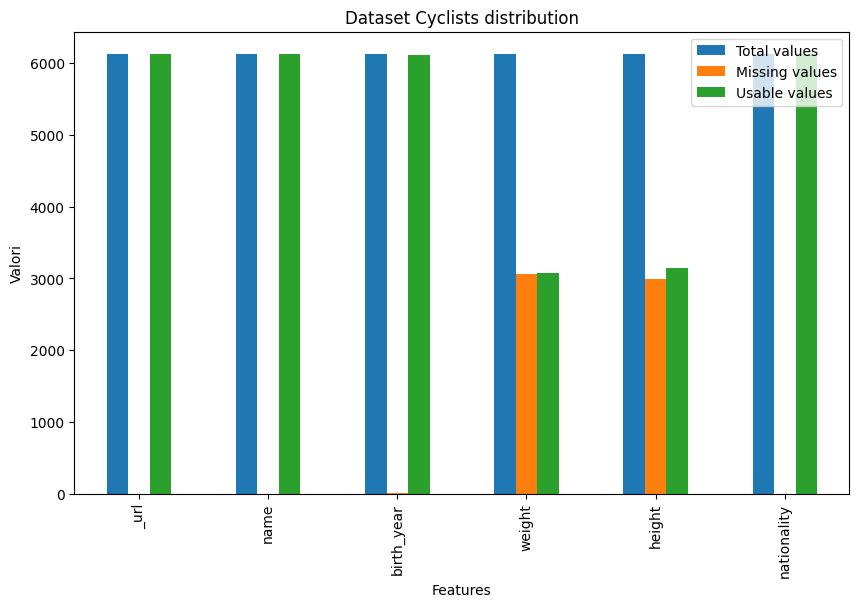

In [32]:
PlotMissingUsableData(DatasetCyclists, "Cyclists")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "weight" e "height".
- Nella colonna "birth_year" manca qualche dato e su "nationality" un solo dato.

### Correct values check (Margherita)

### Features distributions

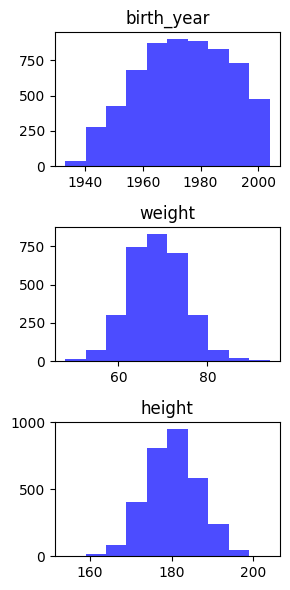

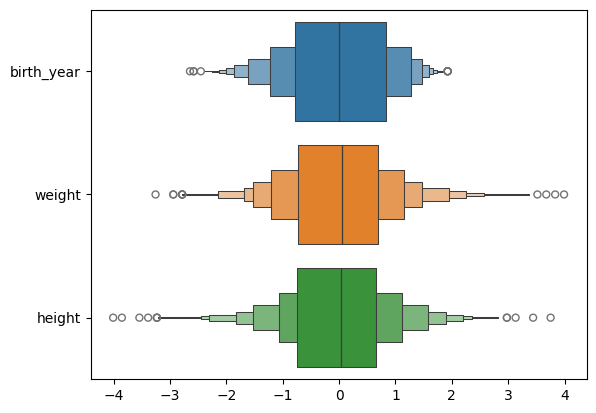

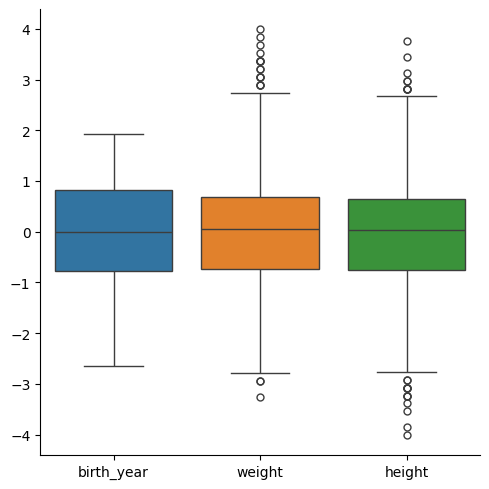

In [33]:
InterestingFeatures = ["birth_year", "weight", "height"]

PlotDistributionFeatures(DatasetCyclists, InterestingFeatures)

Le distribuzioni seguono tutte una distribuzione gaussiana è la presenza di outlier è più (ma non troppo) presente sulle colonne "weight" e "height".

### Correlations between features (Oleskiy)

What follows are the most important relationships between features, in my opinion, to show.
To see a complete analysis go to file [OleksiyRelFeature.ipynb](OleksiyRelFeature.ipynb)

#### Begin the analysis with a correlation matrix

Let's begin the analysis with a big correlation matrix that contains all the significant features from the `DatasetCyclists` and `DatasetRaces` frames.

`

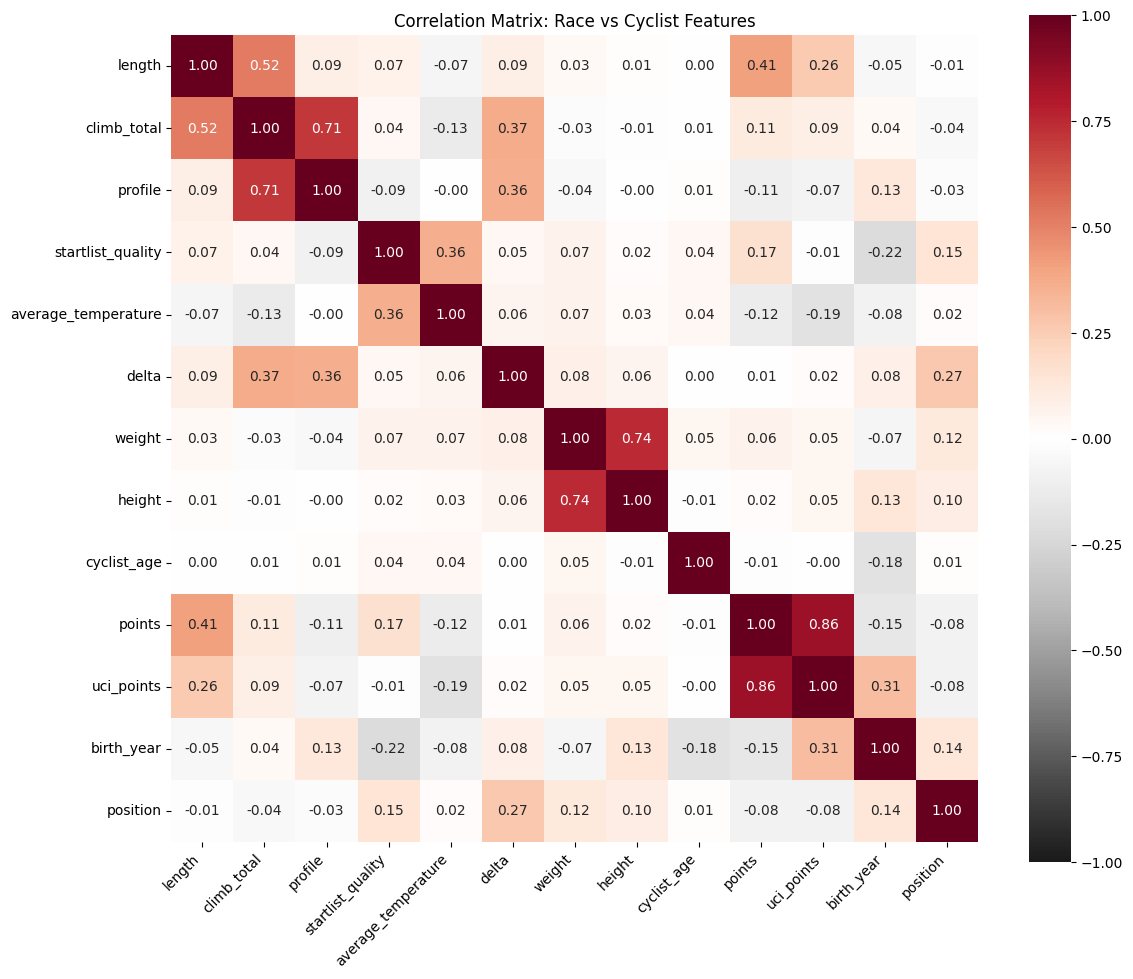

In [11]:
columns_of_interest = [
        'length', 'climb_total', 'profile', 'startlist_quality', 
        'average_temperature', 'delta', 'weight', 'height', 
        'cyclist_age', 'points', 'uci_points', 'birth_year', 'position'
]

def create_correlation_matrix(merged_df, columns_of_interest=columns_of_interest):
    # Select the relevant columns from the correlation matrix shown in the image
    
    
    # Create a copy of races dataframe with selected columns
    race_data = merged_df[columns_of_interest].copy()
    
    # Calculate correlation matrix
    corr_matrix = race_data.corr(method='pearson')
    
    # Create the visualization
    plt.figure(figsize=(12, 10))
    
    # Create heatmap
    seaborn.heatmap(corr_matrix, 
                annot=True,  # Show correlation values
                fmt='.2f',   # Format to 2 decimal places
                cmap='RdGy_r',  # Red-Grey-Blue colormap reversed
                vmin=-1,     # Minimum correlation value
                vmax=1,      # Maximum correlation value
                center=0,    # Center the colormap at 0
                square=True) # Make the plot square-shaped
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add title
    plt.title('Correlation Matrix: Race vs Cyclist Features')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf(), corr_matrix


fig,corr_matrix = create_correlation_matrix(merged_df=MergedDataset)
plt.show()
plt.close(fig)


#### Since the best correlations might be hard to see, I will show below the top 6 positive and negative ones.


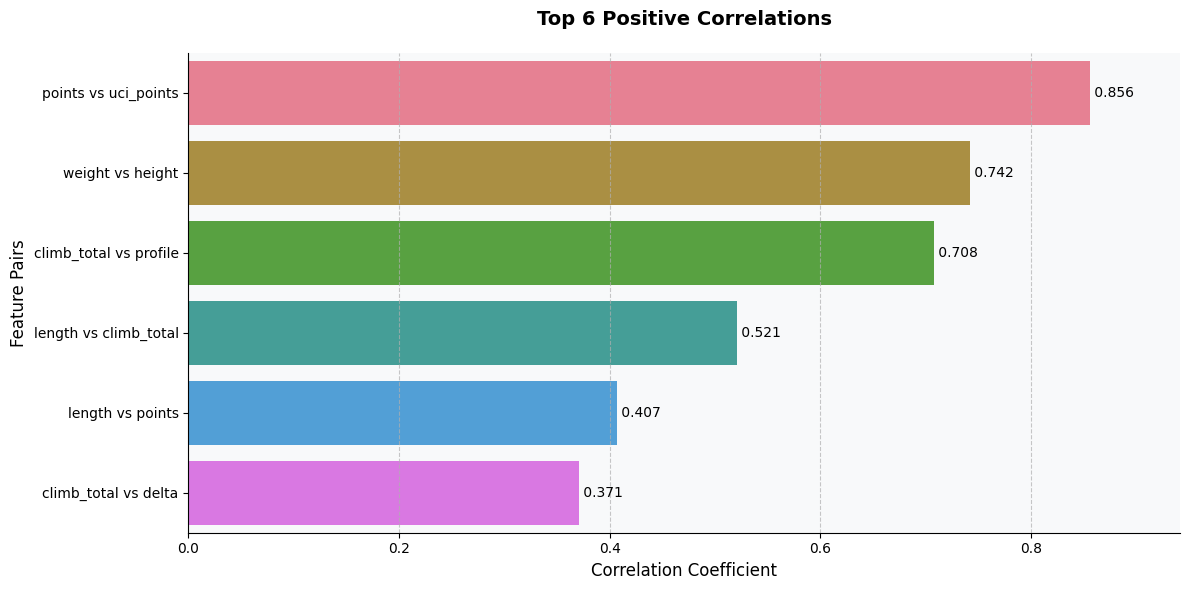

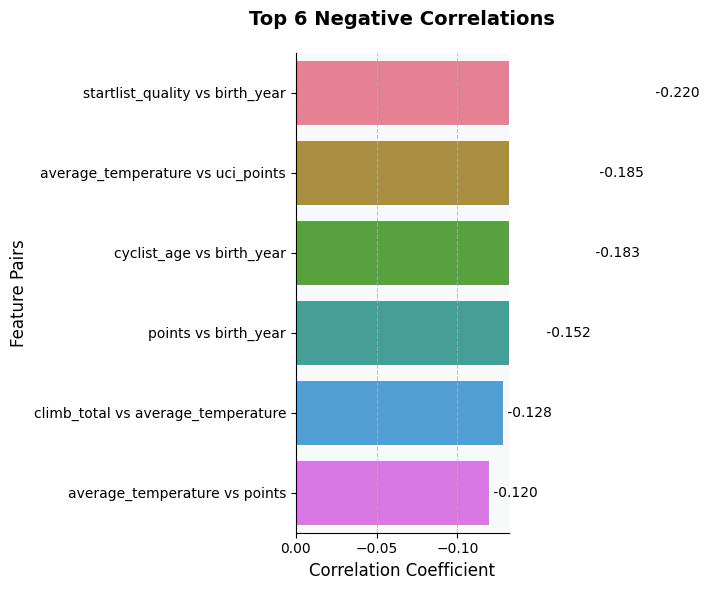

In [44]:
def display_top_correlations(corr_matrix, n=6):
    # Get upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    
    # Stack the correlations and sort by absolute value
    stacked = upper.stack()
    sorted_corr = stacked.loc[stacked.sort_values(ascending=False).index]
    correlations = {
        "Positive": {
            "Features Pair": [],
            "Correlation": []
        },
        "Negative": {
            "Features Pair": [],
            "Correlation": []
        }
    }
    for i in range(min(n, len(sorted_corr))):
        # pair = sorted_corr.index[i]
        # value = sorted_corr.iloc[i]
        # print(f"{pair[0]} vs {pair[1]}: {value:.3f}")
        correlations["Positive"]["Features Pair"].append(f"{sorted_corr.index[i][0]} vs {sorted_corr.index[i][1]}")
        correlations["Positive"]["Correlation"].append(sorted_corr.iloc[i])
        correlations["Negative"]["Features Pair"].append(f"{sorted_corr.index[-(i+1)][0]} vs {sorted_corr.index[-(i+1)][1]}")
        correlations["Negative"]["Correlation"].append(sorted_corr.iloc[-(i+1)])
    
    return pd.DataFrame(correlations["Positive"]), pd.DataFrame(correlations["Negative"])
        
def print_abs_top_correlations(df, message):
    # Create horizontal bar chart
    

    seaborn.set_palette("husl")

    # Create the figure and axis with a specific size
    fig, ax = plt.subplots(figsize=(12, 6))

    seaborn.barplot(
        data=df,
        y='Features Pair',
        x='Correlation',
        ax=ax,
        hue='Features Pair',  # This gives each bar a unique color
        legend=False  # Don't show the legend since it's redundant
    )

    # Customize the plot
    ax.set_title(message, pad=20, fontsize=14, fontweight='bold')
    ax.set_xlabel('Correlation Coefficient', fontsize=12)
    ax.set_ylabel('Feature Pairs', fontsize=12)

    # Add value labels on the bars
    for i, v in enumerate(df['Correlation']):
        ax.text(v, i, f' {v:.3f}', va='center', fontsize=10)

    # Customize grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    # Set the x-axis limits to make it visually appealing
    ax.set_xlim(0, max(df['Correlation']) * 1.1)

    # Add a vertical line at x=0
    ax.axvline(x=0, color='black', linewidth=0.5)

    # Customize the background
    ax.set_facecolor('#f8f9fa')
    fig.patch.set_facecolor('white')

    # Remove top and right spines
    seaborn.despine()

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()
    plt.close()

dfs = display_top_correlations(corr_matrix)

# Create the figure and axis with a specific size
print_abs_top_correlations(dfs[0], "Top 6 Positive Correlations")
print_abs_top_correlations(dfs[1], "Top 6 Negative Correlations")






#### Comments on the positive correlations
There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.There are expected positive correlations like `weight` and `height`. Something that might be of interest is the correlation between `points` and `uci_points`. What is surprising is the small correlation between `climb_total` and `delta`, but it probably makes sense since the bigger the climb, the further cyclists will arrive from the first one.

#### Comments on the negative correlations

There is a small correlation between the ```startlist_quality``` feature and the birth_year, which might suggest that if the race has many young riders, it will have lower `startlist_quality`. The negative correlation between points and `birth_year` makes sense since younger cyclists tend to have fewer `points`.

There is a slightly negative correlation between the `average_temperature` and `uci_points` that can be further investigated.


#### `weight`, `height` and race `profile` influence the `position`? 

Let's see if the `weight` and `height` of the riders, coupled with the race `profile`, influence the position of the cyclist.

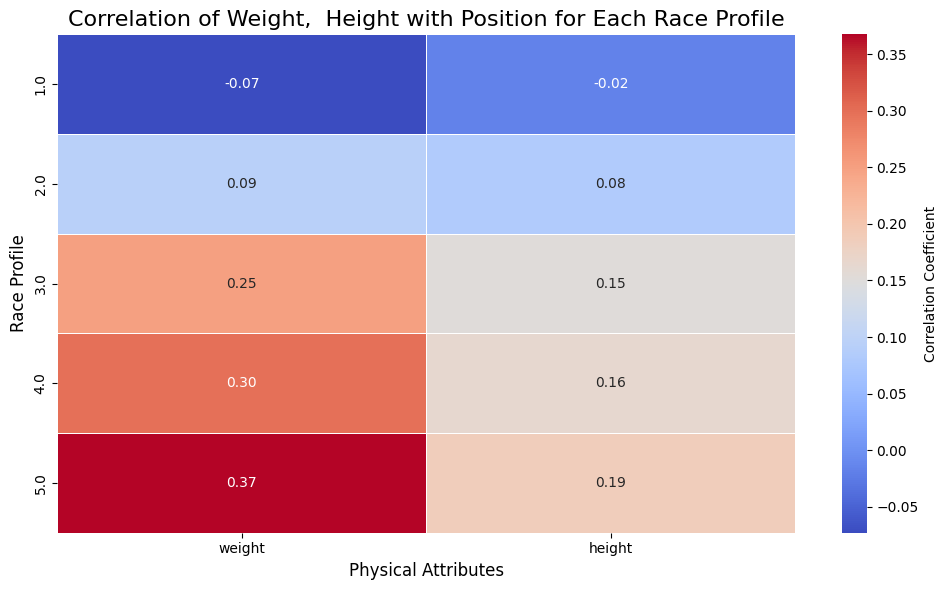

In [56]:
whpp_cor_feat = ['weight', 'height', 'position', 'profile']
whpp_cor_df = MergedDataset[whpp_cor_feat].copy()

correlations = whpp_cor_df.groupby('profile')[['weight', 'height', 'position']].corr()

correlations = correlations.xs('position', level=1).drop('position', axis=1)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
heatmap = seaborn.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

# Customize the heatmap
heatmap.set_title('Correlation of Weight,  Height with Position for Each Race Profile', fontsize=16)
heatmap.set_xlabel('Physical Attributes', fontsize=12)
heatmap.set_ylabel('Race Profile', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
plt.close()
del whpp_cor_df

It clearly shows that lighter riders tend to finish in better positions when the climbing is significant, which makes perfect sense. The height has a smaller correlation, but we can still say that height might influence the final position of the rider if the race has a high profile.

#### Correlation between `average_temperature`, `nationality`, and `age_group`

Even though the `average_temperature` column has many `NaN` values, it is interesting to examine the mentioned correlations.



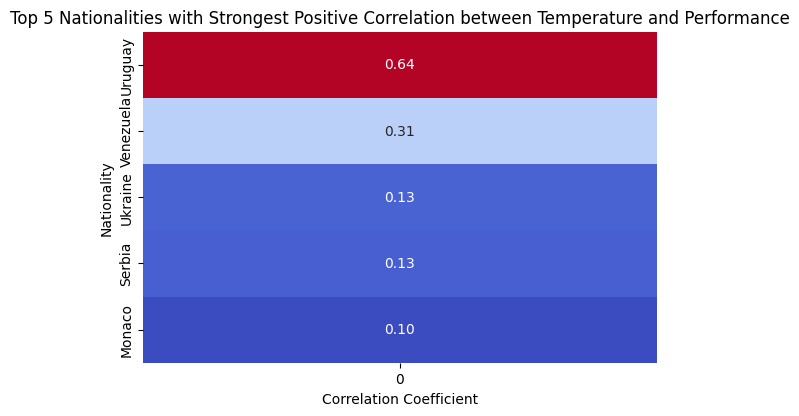

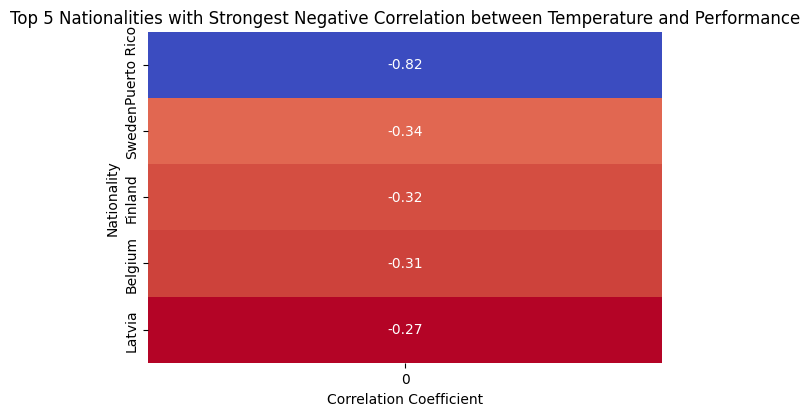

In [13]:
def calc_group_correlations(data, group_column):
    correlations = {}
    for group in data[group_column].unique():
        group_data = data[data[group_column] == group]
        if len(group_data) > 1:  # Ensure we have enough data points
            if group_data['average_temperature'].nunique() > 1 and group_data['average_temperature'].std() > 0 and group_data['points'].std() > 0:  # Ensure temperature varies
                corr, _ = stats.pearsonr(group_data['average_temperature'], group_data['points'])
                correlations[group] = corr
    return pd.Series(correlations)

ana_cor_feat = ['average_temperature', 'points', 'uci_points', 'position', 'nationality']
ana_cor_df = MergedDataset[ana_cor_feat].copy()

# where uci_points is not null and position is null insert insert uci_points in position
ana_cor_df['position'] = ana_cor_df['position'].fillna(ana_cor_df['uci_points'])
ana_cor_df.dropna(subset=['points', 'average_temperature'], inplace=True)

nationality_correlations = calc_group_correlations(ana_cor_df, 'nationality')

heatmap_data = nationality_correlations.nlargest(5).to_frame()


heatmap = seaborn.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Positive Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()

heatmap = seaborn.heatmap(nationality_correlations.nsmallest(5).to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
heatmap.set_title('Top 5 Nationalities with Strongest Negative Correlation between Temperature and Performance')
heatmap.set_xlabel('Correlation Coefficient')
heatmap.set_ylabel('Nationality')

plt.tight_layout(pad=3.0, w_pad=1.0, h_pad=1.0)
plt.show()
plt.close()
del ana_cor_df

As the correlation shows, riders coming from warmer countries may perform better in higher temperatures. In contrast, athletes from colder countries might struggle as temperatures rise. The outlier here is Puerto Rico, which could be interesting to investigate further.

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **cyclists**:

- 

## Dataset race

### Missing values distributions

                     Total values  Missing values  Usable values
Elements                                                        
_url                       589865               0         589865
name                       589865               0         589865
points                     589865             477         589388
uci_points                 589865          338779         251086
length                     589865               0         589865
climb_total                589865          147045         442820
profile                    589865          148194         441671
startlist_quality          589865               0         589865
average_temperature        589865          559932          29933
date                       589865               0         589865
position                   589865               0         589865
cyclist                    589865               0         589865
cyclist_age                589865             113         589752
is_tarmac                

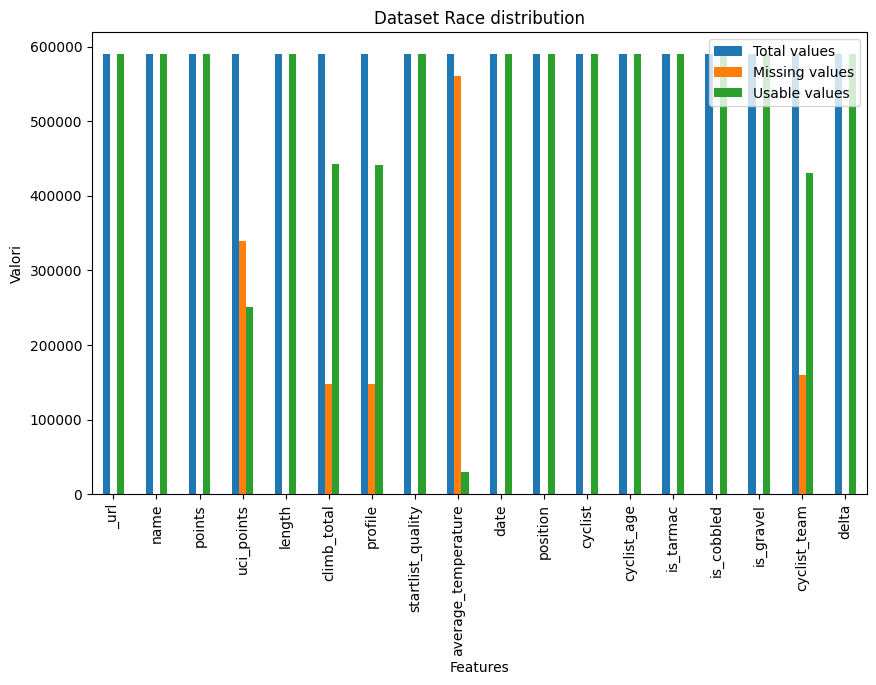

In [36]:
PlotMissingUsableData(DatasetRace, "Race")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "uci_points", "average_temperature", "cyclists_team", "climb_total" e "profile".

### Correct values check (Margherita)

### Features distributions

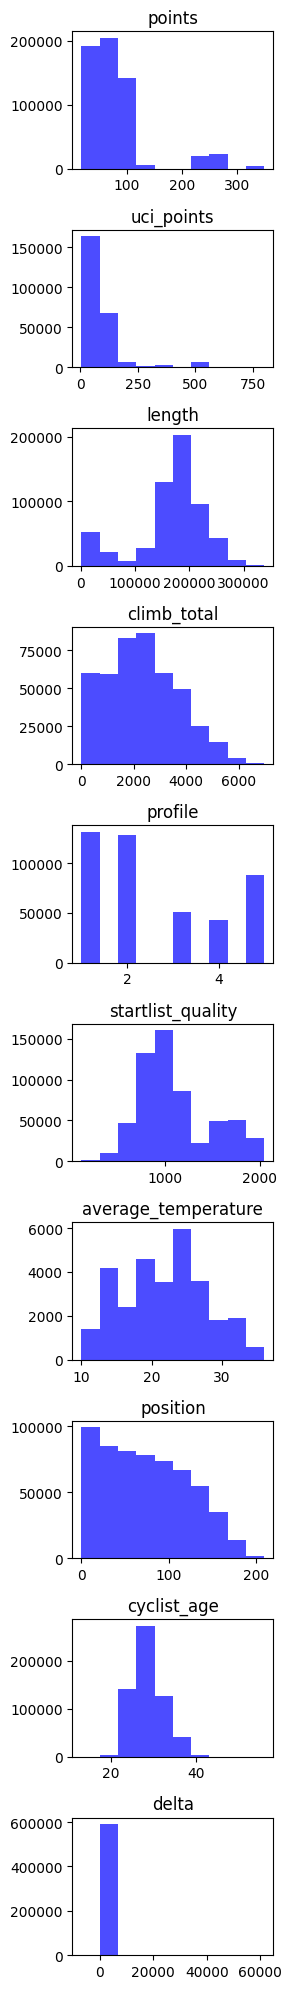

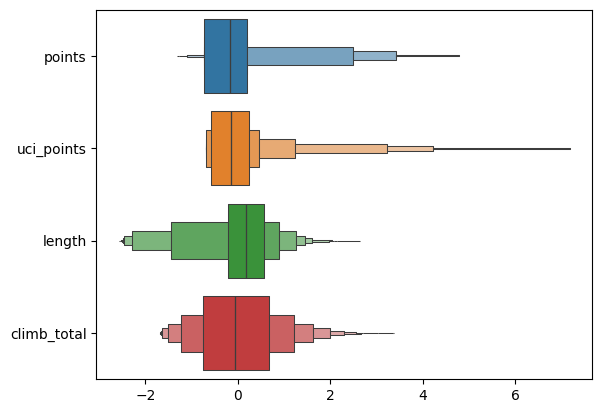

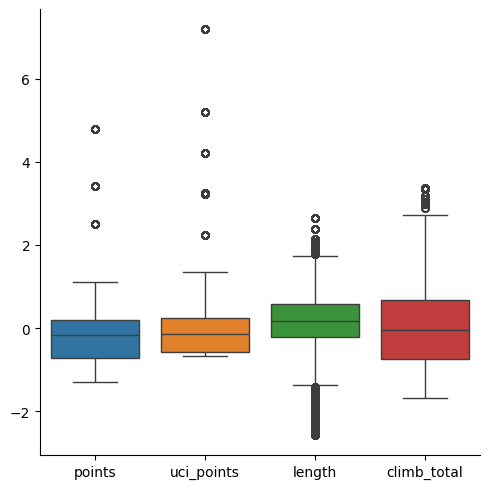

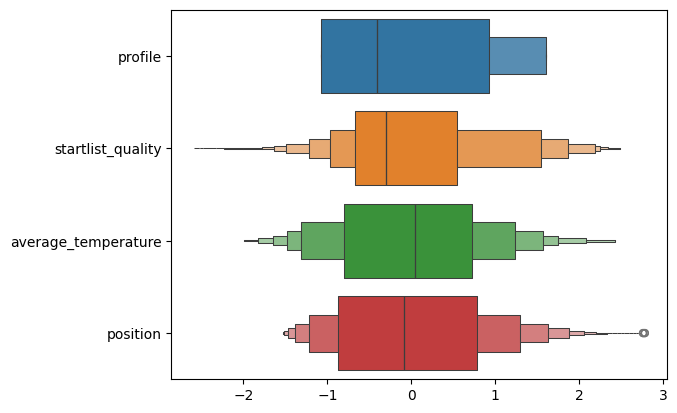

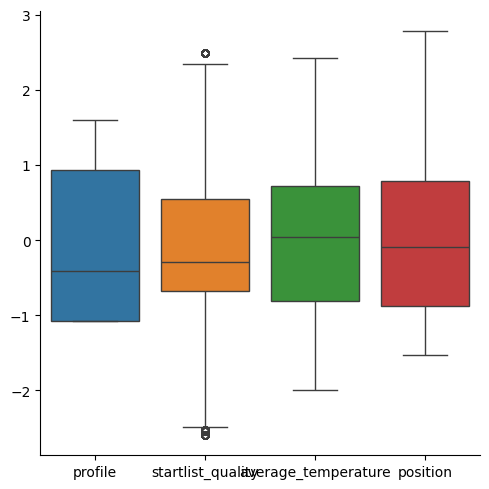

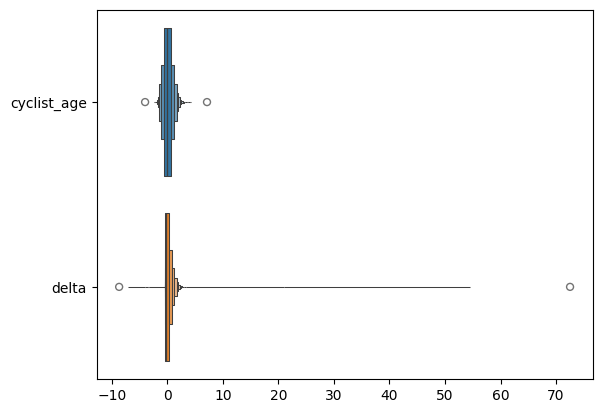

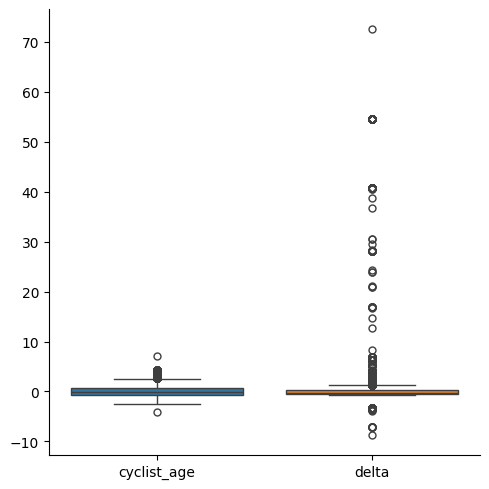

In [37]:
InterestingFeatures = ["points", "uci_points", "length", "climb_total", "profile",
                       "startlist_quality", "average_temperature", "position", "cyclist_age", "delta"]

PlotDistributionFeatures(DatasetRace, InterestingFeatures)

Nella maggior parte delle colonne ci sono distribuzioni non uniformi e la presenza di outlier è sopratutto su "delta", "cyclists_age" e "climb_total" 

### Correlations between features (Oleskiy)

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **race**:

- 

# **Data cleaning**

## Dataset cyclists

### Fill nationality data missing

Si va a riempire il dato mancante nella colonna "nationality", il valore è stato cercato su Google.

In [38]:
ScottDavisIndex = DatasetCyclists[DatasetCyclists["nationality"].isnull()].index[0]
DatasetCyclists.loc[ScottDavisIndex, "nationality"] = "Great Britain"

### Fill data of weight and height columns

Si va a riempire le colonne di "height" e "weight" sfruttando i dati tra loro. Si è scoperto che hanno un alta correlazione.

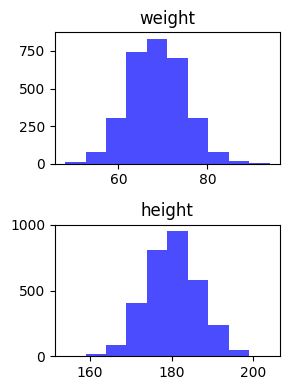

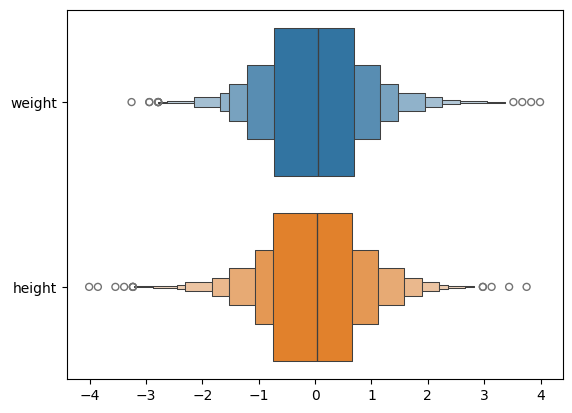

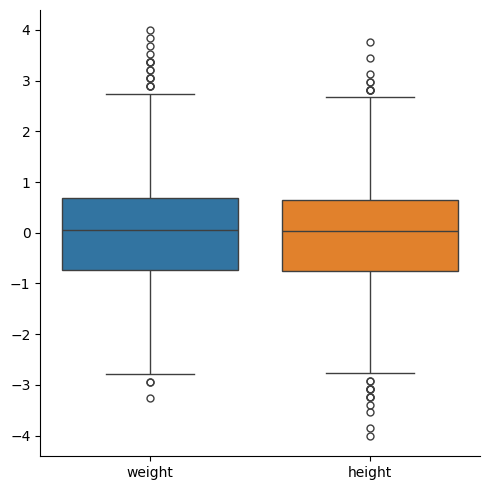

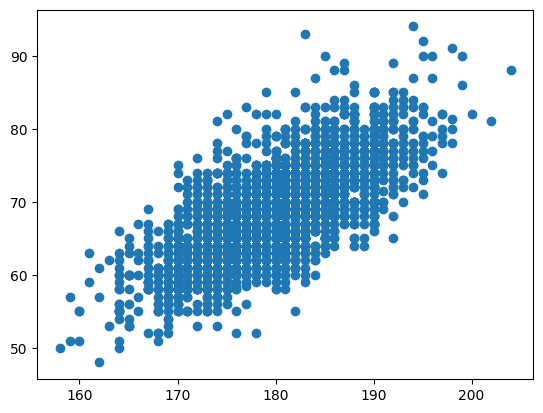

In [39]:
#Inferenza sulle colonne weight ed height
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle 2 colonne tra loro.

In [40]:
TrainData = DatasetCyclists.dropna(subset=['weight', 'height'])

#Predizione dei valori sulle righe dove height c'è e weight manca (regressore lineare) e viceversa (con un altro regressore lineare)
HeightPredictor = LinearRegression()
WeightPredictor = LinearRegression()

#Allenamento dei regressori
for _ in range(1):
    HeightPredictor.fit(TrainData[['weight']], TrainData[['height']])
    WeightPredictor.fit(TrainData[['height']], TrainData[['weight']])

#Calcolo degl' indici dove andare a riempire i valori
HeightSlot = DatasetCyclists[DatasetCyclists['height'].isna() & DatasetCyclists['weight'].notna()]
WeightSlot = DatasetCyclists[DatasetCyclists['weight'].isna() & DatasetCyclists['height'].notna()]

#Calcolo dei valori mancanti
DatasetCyclists.loc[WeightSlot.index, 'weight'] = WeightPredictor.predict(WeightSlot[['height']])
DatasetCyclists.loc[HeightSlot.index, 'height'] = HeightPredictor.predict(HeightSlot[['weight']])

#Predizione dei valori sulle righe dove manca sia height che weight (distribuzione)
ColumnsCleaned = DatasetCyclists[["weight", "height"]].dropna()

#Creazione della distribuzione multivariata (2 dimensioni)
Distribution = multivariate_normal([ColumnsCleaned["weight"].mean(), ColumnsCleaned["height"].mean()],
                                   np.cov(ColumnsCleaned["weight"], ColumnsCleaned["height"]))

#Calcolo degl' indici dei valori missing
MissingIndex = DatasetCyclists[DatasetCyclists[['weight', 'height']].isna().any(axis=1)].index

#Riempimento dei valori mancanti con la distribuzione multivariata
DatasetCyclists.loc[MissingIndex, ['weight', 'height']] = Distribution.rvs(size=len(MissingIndex))


Si allena un regressore lineare per inferire sui dati "weight".
Si allena un regressore lineare per inferire sui dati "height".

Per i regressori si prepara un insieme di dati che sono le coppie dove ci sono entrambi i valori.

Si costruisce una distribuzione multivariata (2 dimensioni) usando i dati a disposizione + i dati inferiti con i regressori, dopodichè si campionano dei dati per poter inferire sui dati mancanti.

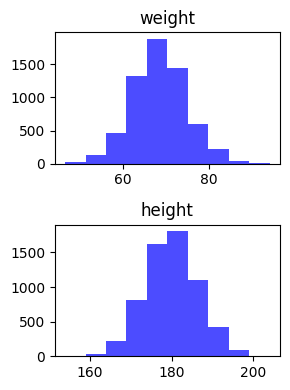

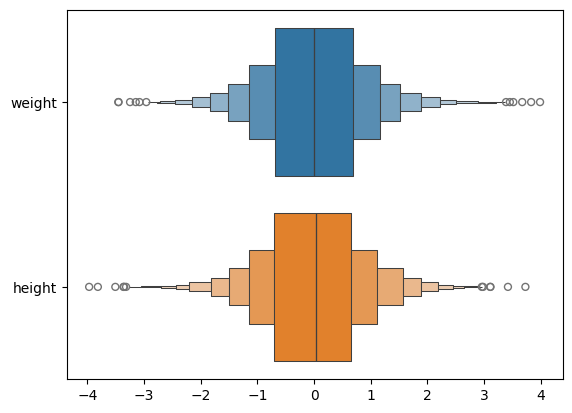

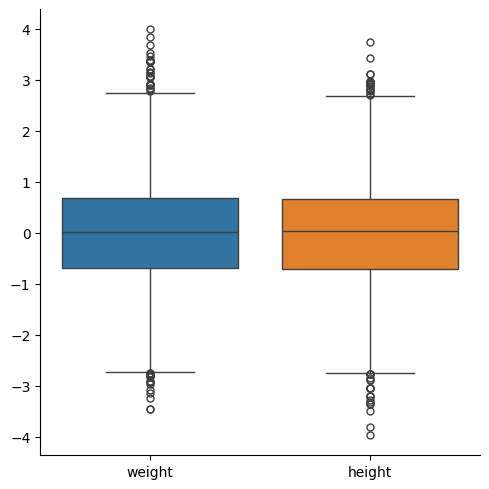

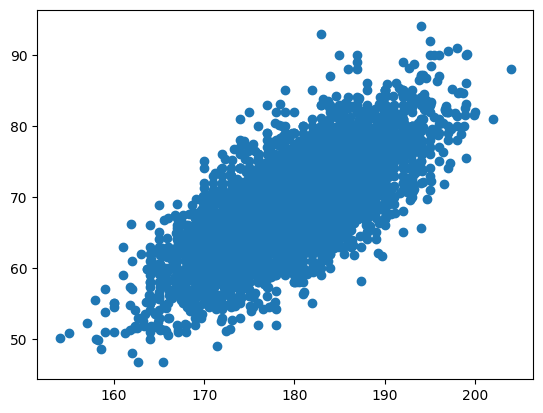

In [41]:
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle colonne tra loro dopo il riempimento dei dati mancanti.

### Fill data of birth_year column (Riccardo)

### View final dataset cleaned

             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134              13           6121
weight               6134               0           6134
height               6134               0           6134
nationality          6134               0           6134


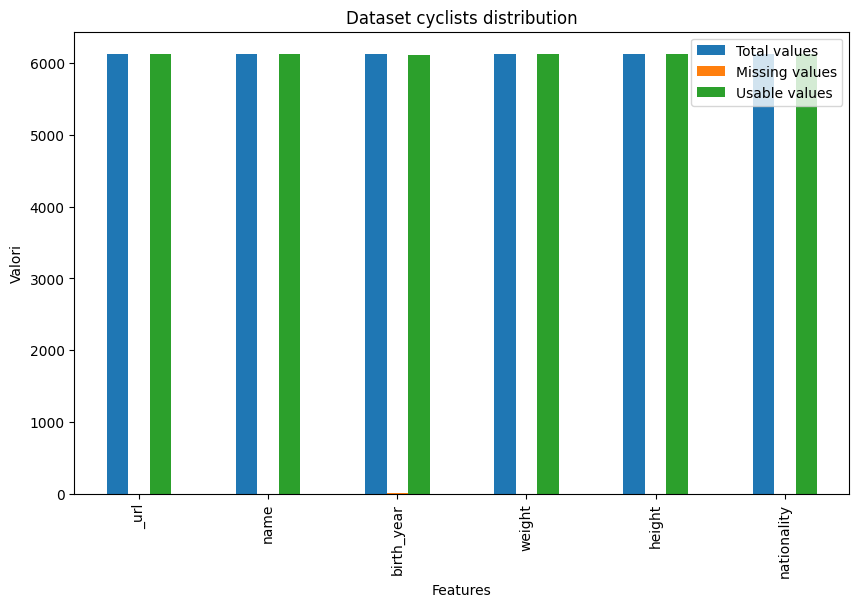

In [42]:
PlotMissingUsableData(DatasetCyclists, "cyclists")

## Dataset race

### Delete average_temperature feature

Si toglie la tabella "average_temperature", è irrilevante e non ha nessuna correlazione con altre tabelle.

In [43]:
#Tolgo la feautres average_temperature
del DatasetRace["average_temperature"]

### Fill data of climb_total and profile columns (Oleskiy)

### Fill data of points and uci_points columns (Oleskiy)

### Fill data of cyclists_age and cyclists_team columns (Riccardo)

### View final dataset cleaned

                   Total values  Missing values  Usable values
Elements                                                      
_url                     589865               0         589865
name                     589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0         589865
cyclist                  589865               0         589865
cyclist_age              589865             113         589752
is_tarmac                589865               0         589865
is_cobbled               589865               0        

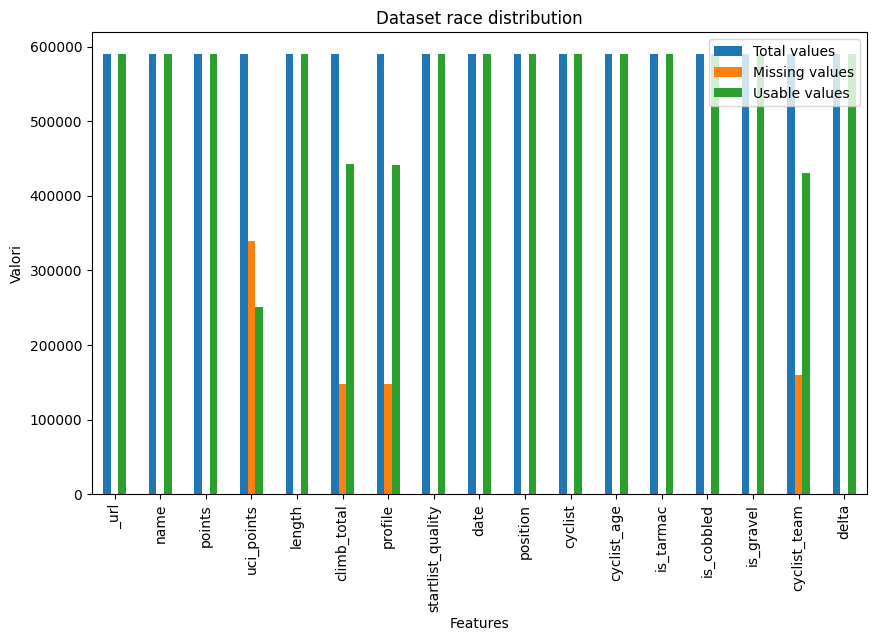

In [44]:
PlotMissingUsableData(DatasetRace, "race")

# **Feature engineering**

Si fa il merge delle tabelle in un unica tabella, prendendo come chiavi di riferimento la colonna "_url" del dataset cyclists e la colonna "cyclists" del dataset race.

                   Total values  Missing values  Usable values
Elements                                                      
name_cyclist             589865               0         589865
birth_year               589865             113         589752
weight                   589865               0         589865
height                   589865               0         589865
nationality              589865               0         589865
name_race                589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0        

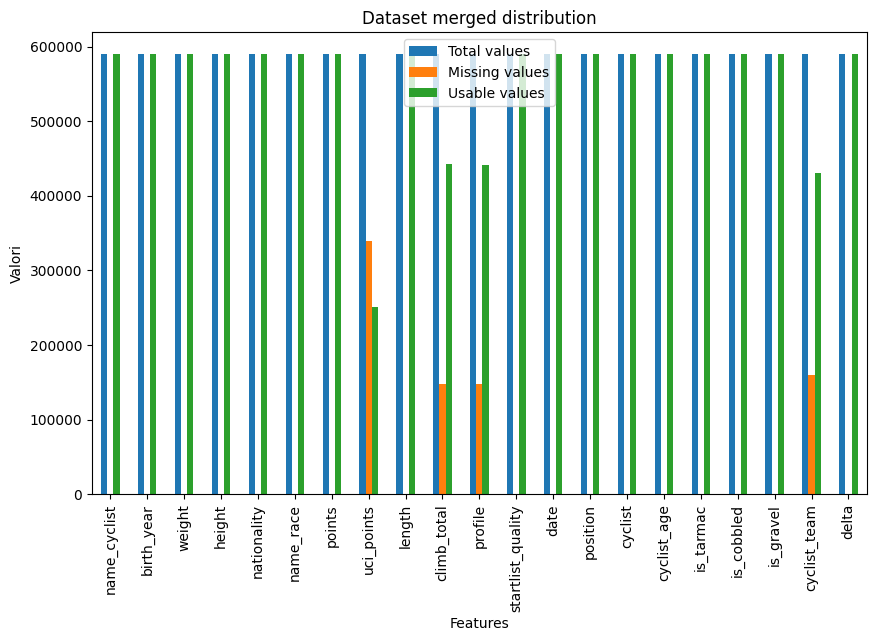

In [45]:
MergeDataset = pd.merge(DatasetCyclists, DatasetRace, left_on = "_url", right_on = "cyclist")

del MergeDataset["name_x"]
del MergeDataset["name_y"]

MergeDataset.rename(columns = {"_url_x": "name_cyclist"}, inplace = True)
MergeDataset.rename(columns = {"_url_y": "name_race"}, inplace = True)

PlotMissingUsableData(MergeDataset, "merged")

# - (Analysis a choosed situation)